# **Análisis Exploratorio de Datos**

## **1. Limpieza**

### **1.1. Importar Datos y librerías**

In [ ]:

from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import math
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [ ]:
# Configuración estética opcional
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Cargar los datos
df = pd.read_csv("diabetic_data.csv")

### **1.2 Análisis**


En esta sección analizamos el dataset, su contenido, la presencia de valores faltantes y su tratamiento para preparar los datos para el análisis posterior.

#### **1.2.1 Observación de los Datos**

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [ ]:
# Mostrar todas las columnas al imprimir
pd.set_option('display.max_columns', None)

# Mostrar las primeras filas del DataFrame
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,250.83,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,276,250.01,255,9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,648,250,V27,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,8,250.43,403,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,197,157,250,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


Al observar los datos, nos llamó la atención el caso particular de tres variables: ***diag_1***, ***diag_2*** y ***diag_3***. Estas variables contienen códigos de diagnóstico en formato ICD-9, los cuales, en su forma actual —principalmente números enteros— resultan poco interpretables para un análisis clínico o estadístico directo.

No obstante, al revisar el artículo de investigación ***"Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records"***, identificamos una propuesta para agrupar estos códigos en categorías médicas más comprensibles (como enfermedades circulatorias, respiratorias, digestivas, etc.).

Por consiguiente, decidimos llevar a cabo esta transformación, convirtiendo los códigos ICD-9 en categorías médicas más claras y relevantes para nuestro análisis de reingresos hospitalarios.

In [ ]:
def map_icd9(code):
    if pd.isnull(code):
        return 'Desconocido'

    if code == '?':
        return '?'  # mantener el signo de interrogación tal cual

    try:
        code_str = str(code)

        # Casos especiales tipo string
        if code_str.startswith('V') or code_str.startswith('E'):
            return 'Causas externas'

        code_float = float(code_str)

        if (390 <= code_float <= 459) or (code_float == 785):
            return 'Circulatorio'
        elif (460 <= code_float <= 519) or (code_float == 786):
            return 'Respiratorio'
        elif (520 <= code_float <= 579) or (code_float == 787):
            return 'Digestivo'
        elif 250 <= code_float < 251:  # solo el 250, incluye decimales
            return 'Diabetes'
        elif 800 <= code_float <= 999:
            return 'Herida'
        elif 710 <= code_float <= 739:
            return 'Musculoesquelético'
        elif (580 <= code_float <= 629) or (code_float == 788):
            return 'Genitourinario'
        elif 140 <= code_float <= 239:
            return 'Neoplasmas'
        elif (780 <= code_float <= 784) or (790 <= code_float <= 799):
            return 'Síntomas mal definidos'
        elif (240 <= code_float <= 279) and not (250 <= code_float < 251):
            return 'Endocrino y metabolismo (sin diabetes)'
        elif (680 <= code_float <= 709) or (code_float == 782):
            return 'Piel y tejido subcutáneo'
        elif 1 <= code_float <= 139:
            return 'Infecciosas y parasitarias'
        elif 290 <= code_float <= 319:
            return 'Trastornos mentales'
        elif 280 <= code_float <= 289:
            return 'Sangre y órganos hematopoyéticos'
        elif 320 <= code_float <= 359:
            return 'Sistema nervioso'
        elif 630 <= code_float <= 679:
            return 'Embarazo y puerperio'
        elif 360 <= code_float <= 389:
            return 'Órganos de los sentidos'
        elif 740 <= code_float <= 759:
            return 'Anomalías congénitas'
        else:
            return 'Otro'

    except:
        return 'Otro'



In [ ]:
# Transformación de las variables de diagnostico
df['diag_1'] = df['diag_1'].apply(map_icd9)
df['diag_2'] = df['diag_2'].apply(map_icd9)
df['diag_3'] = df['diag_3'].apply(map_icd9)

df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,41,0,1,0,0,0,Diabetes,?,?,1,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,59,0,18,0,0,0,Endocrino y metabolismo (sin diabetes),Diabetes,Endocrino y metabolismo (sin diabetes),9,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,11,5,13,2,0,1,Embarazo y puerperio,Diabetes,Causas externas,6,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,44,1,16,0,0,0,Infecciosas y parasitarias,Diabetes,Circulatorio,7,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,51,0,8,0,0,0,Neoplasmas,Neoplasmas,Diabetes,5,NaN,NaN,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


C:\Users\Janus\AppData\Local\Temp/ipykernel_18804/2003688612.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='diag_1', data=df, order=df['diag_1'].value_counts().index, palette='viridis')
C:\Users\Janus\AppData\Local\Temp/ipykernel_18804/2003688612.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='diag_2', data=df, order=df['diag_2'].value_counts().index, palette='magma')
C:\Users\Janus\AppData\Local\Temp/ipykernel_18804/2003688612.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y='diag_3', data=df, order=df['diag_3'].

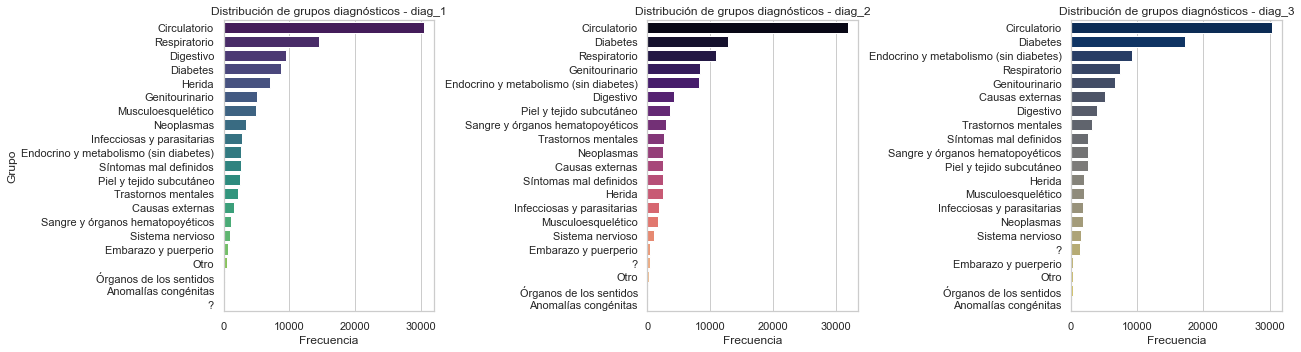

In [ ]:
# Estilo general
sns.set(style="whitegrid")
plt.figure(figsize=(18, 5))

# Gráfico para diag_1
plt.subplot(1, 3, 1)
sns.countplot(y='diag_1', data=df, order=df['diag_1'].value_counts().index, palette='viridis')
plt.title('Distribución de grupos diagnósticos - diag_1')
plt.xlabel('Frecuencia')
plt.ylabel('Grupo')

# Gráfico para diag_2
plt.subplot(1, 3, 2)
sns.countplot(y='diag_2', data=df, order=df['diag_2'].value_counts().index, palette='magma')
plt.title('Distribución de grupos diagnósticos - diag_2')
plt.xlabel('Frecuencia')
plt.ylabel('')

# Gráfico para diag_3
plt.subplot(1, 3, 3)
sns.countplot(y='diag_3', data=df, order=df['diag_3'].value_counts().index, palette='cividis')
plt.title('Distribución de grupos diagnósticos - diag_3')
plt.xlabel('Frecuencia')
plt.ylabel('')

plt.tight_layout()
plt.show()

#### **1.2.2 Análisis de Valores Faltantes**


En primera instancia, recurrimos a hacer un mapa de calor y una tabla de valores faltantes para una primera inspección.

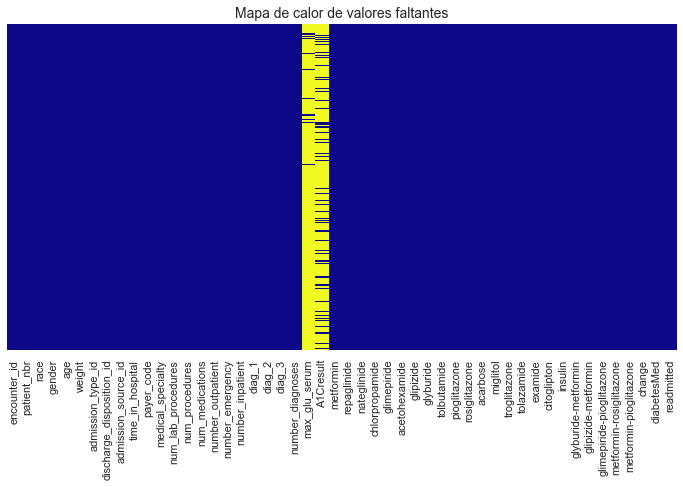

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='plasma')
plt.title("Mapa de calor de valores faltantes", fontsize=14)
plt.show()

In [ ]:
faltantes = df.isnull().sum()
porcentaje = (faltantes / len(df)) * 100

tabla_faltantes = pd.DataFrame({
    'Valores faltantes': faltantes,
    'Porcentaje (%)': porcentaje
})

# Mostrar solo columnas con NA
tabla_faltantes = tabla_faltantes[tabla_faltantes['Valores faltantes'] > 0]
tabla_faltantes.sort_values('Porcentaje (%)', ascending=False)

,Valores faltantes,Porcentaje (%)
max_glu_serum,96420,94.746772
A1Cresult,84748,83.277322


En este análisis identificamos que solo dos variables, ***`max_glu_serum`*** y ***`A1Cresult`***, presentaban valores ausentes según Python, con un 94.74% y 83.27% de valores faltantes respectivamente. A primera vista, esta alta proporción de NaN sugeriría que estas variables deberían eliminarse del análisis.

Sin embargo, al examinar más a fondo el contexto del dataset, notamos que ambas variables son categóricas y contienen una categoría denominada "None", la cual fue erróneamente interpretada por Python como un valor nulo. (vealo en la siguiente tabla)

| Variable       | Tipo       | Descripción |
|----------------|------------|-------------|
| `max_glu_serum`| Categórica | Resultado máximo de glucosa en suero. Valores: >200, >300, normal, ***none***. |
| `A1Cresult`    | Categórica | Resultado de hemoglobina A1C. Valores: >8, >7, normal, ***none***. |

Adicionalmente, descubrimos que en este conjunto de datos los valores realmente faltantes se representan mediante el símbolo "?", por lo que no son detectados automáticamente como nulos al cargar el archivo. (Vealo en la siguiente Imagen)

![Mapa de calor de valores faltantes](Imagenes/Valores_Faltantes_Datos.png)

El paso a seguir es reemplazar manualmente estos símbolos para permitir un tratamiento adecuado de los valores ausentes en etapas posteriores del análisis.

In [ ]:

#Se reemplaza los "na" que en realidad son una categoria por el string none
df['max_glu_serum'] = df['max_glu_serum'].fillna('none')
df['A1Cresult'] =df['A1Cresult'].fillna('none')

# Reemplazar '?' por NaN
df= df.replace('?', np.nan)

faltantes = df.isnull().sum()
porcentaje = (faltantes / len(df)) * 100

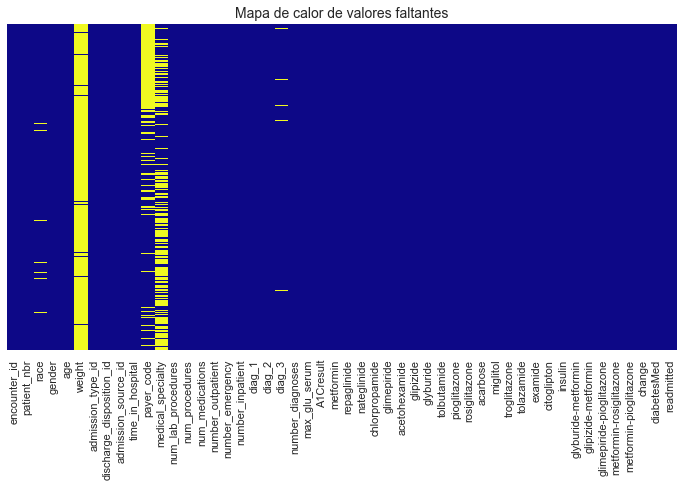

In [ ]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='plasma')
plt.title("Mapa de calor de valores faltantes", fontsize=14)
plt.show()

Es evidente que, tras reemplazar el signo "?" por valores nulos (NaN), se revelan los verdaderos datos faltantes en el conjunto. Asimismo, se puede observar que las variables `max_glu_serum` y `A1Cresult` ya no presentan valores ausentes, ya que la categoría "none" fue correctamente interpretada como una respuesta válida.

El siguiente paso consiste en evaluar el tratamiento adecuado para los valores faltantes restantes, considerando tanto la naturaleza de cada variable como el porcentaje de datos ausentes que presenta en el conjunto.

In [ ]:
tabla_faltantes = pd.DataFrame({
    'Valores faltantes': faltantes,
    'Porcentaje (%)': porcentaje
})

# Mostrar solo columnas con NA
tabla_faltantes = tabla_faltantes[tabla_faltantes['Valores faltantes'] > 0]
tabla_faltantes.sort_values('Porcentaje (%)', ascending=False)

,Valores faltantes,Porcentaje (%)
weight,98569,96.858479
medical_specialty,49949,49.082208
payer_code,40256,39.557416
race,2273,2.233555
diag_3,1423,1.398306
diag_2,358,0.351787
diag_1,21,0.020636


Ahora observamos que la variable ***weight*** presenta un ***96.86%*** de datos faltantes. Dado que este porcentaje es extremadamente alto, cualquier técnica de imputación resultaría ineficiente y podría introducir sesgos significativos en el análisis, comprometiendo la validez de los resultados. Por esta razón, se decide excluir esta variable del análisis.

En el caso de las variables ***medical_specialty*** y ***payer_code***, los porcentajes de valores faltantes son de ***49.08%*** y ***39.55%***, respectivamente. Estos porcentajes no son lo suficientemente bajos como para aplicar técnicas de imputación sin riesgo de introducir sesgos, pero tampoco tan altos como para justificar directamente su eliminación del análisis. Por tanto, recurriremos a agrupar estos NaN es una nueva categoria llamada ***"Unknown"***.

Las variables ***race***, ***diag_1***, ***diag_2*** y ***diag_3*** tienen un porcentaje de NaN del ***2.23%***, ***1.29%***, ***0.35%*** y ***0.02*** respectivamente. Al ser porcentajes  pequeñoS recurriremos a hacer imputación por la moda para los tres casos.

In [ ]:
pd.set_option('display.max_columns', None)
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,41,0,1,0,0,0,Diabetes,NaN,NaN,1,none,none,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,59,0,18,0,0,0,Endocrino y metabolismo (sin diabetes),Diabetes,Endocrino y metabolismo (sin diabetes),9,none,none,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,11,5,13,2,0,1,Embarazo y puerperio,Diabetes,Causas externas,6,none,none,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,44,1,16,0,0,0,Infecciosas y parasitarias,Diabetes,Circulatorio,7,none,none,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,51,0,8,0,0,0,Neoplasmas,Neoplasmas,Diabetes,5,none,none,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


In [ ]:
df.drop(columns=['weight'], inplace=True) #Se elimina

#remplazamos los na por categorias dado que son porcentajes grandes o irrelevantes para imputar
df['medical_specialty'] = df['medical_specialty'].fillna('Unknown')
df['payer_code'] = df['payer_code'].fillna('Unknown')

#Imputación por la moda
var_imputar = ['race', 'diag_1', 'diag_2', 'diag_3']
for name_var in var_imputar:
    moda = df[name_var].mode()[0]
    df[name_var] = df[name_var].fillna(moda)

df.head()    

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),6,25,1,1,Unknown,Pediatrics-Endocrinology,41,0,1,0,0,0,Diabetes,Circulatorio,Circulatorio,1,none,none,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,Unknown,Unknown,59,0,18,0,0,0,Endocrino y metabolismo (sin diabetes),Diabetes,Endocrino y metabolismo (sin diabetes),9,none,none,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,Unknown,Unknown,11,5,13,2,0,1,Embarazo y puerperio,Diabetes,Causas externas,6,none,none,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,Unknown,Unknown,44,1,16,0,0,0,Infecciosas y parasitarias,Diabetes,Circulatorio,7,none,none,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,Unknown,Unknown,51,0,8,0,0,0,Neoplasmas,Neoplasmas,Diabetes,5,none,none,No,No,No,No,No,No,Steady,No,No,No,No,No,No,No,No,No,No,Steady,No,No,No,No,No,Ch,Yes,NO


#### **1.2.3 Codificar las variables categóricas**

En este dataset nos encontramos con una gran proporción de variables categóricas, las cuales debemos codificar para que puedan ser utilizadas posteriormente en un modelo.

In [ ]:
from sklearn.preprocessing import OrdinalEncoder


cat_cols = df.select_dtypes(include='object').columns

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=np.nan)
df[cat_cols] = encoder.fit_transform(df[cat_cols])

df.head()

,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,diag_1,diag_2,diag_3,number_diagnoses,max_glu_serum,A1Cresult,metformin,repaglinide,nateglinide,chlorpropamide,glimepiride,acetohexamide,glipizide,glyburide,tolbutamide,pioglitazone,rosiglitazone,acarbose,miglitol,troglitazone,tolazamide,examide,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,2.0,0.0,0.0,6,25,1,1,16.0,37.0,41,0,1,0,0,0,3.0,2.0,2.0,1,3.0,3.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
1,149190,55629189,2.0,0.0,1.0,1,1,7,3,16.0,71.0,59,0,18,0,0,0,6.0,3.0,6.0,9,3.0,3.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,64410,86047875,0.0,0.0,2.0,1,1,7,2,16.0,71.0,11,5,13,2,0,1,5.0,3.0,1.0,6,3.0,3.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
3,500364,82442376,2.0,1.0,3.0,1,1,7,2,16.0,71.0,44,1,16,0,0,0,9.0,3.0,2.0,7,3.0,3.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0
4,16680,42519267,2.0,1.0,4.0,1,1,7,1,16.0,71.0,51,0,8,0,0,0,11.0,11.0,3.0,5,3.0,3.0,1.0,1.0,1.0,1.0,1.0,0.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0


La codificación se completó correctamente, y en el siguiente fragmento de código se podrá observar qué número fue asignado a cada categoría mediante la codificación.

In [ ]:
#ver como se codificaron las variables
for col, cats in zip(cat_cols, encoder.categories_):
    print(f"Columna: {col}")
    for i, cat in enumerate(cats):
        print(f"  {cat} → {i}")

Columna: race
  AfricanAmerican → 0
  Asian → 1
  Caucasian → 2
  Hispanic → 3
  Other → 4
Columna: gender
  Female → 0
  Male → 1
  Unknown/Invalid → 2
Columna: age
  [0-10) → 0
  [10-20) → 1
  [20-30) → 2
  [30-40) → 3
  [40-50) → 4
  [50-60) → 5
  [60-70) → 6
  [70-80) → 7
  [80-90) → 8
  [90-100) → 9
Columna: payer_code
  BC → 0
  CH → 1
  CM → 2
  CP → 3
  DM → 4
  FR → 5
  HM → 6
  MC → 7
  MD → 8
  MP → 9
  OG → 10
  OT → 11
  PO → 12
  SI → 13
  SP → 14
  UN → 15
  Unknown → 16
  WC → 17
Columna: medical_specialty
  AllergyandImmunology → 0
  Anesthesiology → 1
  Anesthesiology-Pediatric → 2
  Cardiology → 3
  Cardiology-Pediatric → 4
  DCPTEAM → 5
  Dentistry → 6
  Dermatology → 7
  Emergency/Trauma → 8
  Endocrinology → 9
  Endocrinology-Metabolism → 10
  Family/GeneralPractice → 11
  Gastroenterology → 12
  Gynecology → 13
  Hematology → 14
  Hematology/Oncology → 15
  Hospitalist → 16
  InfectiousDiseases → 17
  InternalMedicine → 18
  Nephrology → 19
  Neurology → 20
  Neu

In [ ]:
categorical_vars = [
    "race", "gender", "age", "admission_type_id", "discharge_disposition_id",
    "admission_source_id", "payer_code", "medical_specialty", "max_glu_serum",
    "A1Cresult", "metformin", "repaglinide", "nateglinide", "chlorpropamide",
    "glimepiride", "acetohexamide", "glipizide", "glyburide", "tolbutamide",
    "pioglitazone", "rosiglitazone", "acarbose", "miglitol", "troglitazone",
    "tolazamide", "examide", "citoglipton", "insulin", "glyburide-metformin",
    "glipizide-metformin", "glimepiride-pioglitazone", "metformin-rosiglitazone",
    "metformin-pioglitazone", "change", "diabetesMed", "readmitted"
]

for col in categorical_vars: 
    df[col] = df[col].astype('category')
    df[col].unique()
    df[col].value_counts()

## **2. Análisis Descriptivo**

### **2.1 Variables Numéricas**

#### **2.1.1. Resumen Estadístico**

In [ ]:
columnas_numericas = ["time_in_hospital","num_lab_procedures","num_procedures", "num_medications",
"number_outpatient","number_emergency","number_inpatient","number_diagnoses"]

numericas = df[columnas_numericas]
print(numericas.describe().T)

                       count       mean        std  min   25%   50%   75%  \
time_in_hospital    101766.0   4.395987   2.985108  1.0   2.0   4.0   6.0   
num_lab_procedures  101766.0  43.095641  19.674362  1.0  31.0  44.0  57.0   
num_procedures      101766.0   1.339730   1.705807  0.0   0.0   1.0   2.0   
num_medications     101766.0  16.021844   8.127566  1.0  10.0  15.0  20.0   
number_outpatient   101766.0   0.369357   1.267265  0.0   0.0   0.0   0.0   
number_emergency    101766.0   0.197836   0.930472  0.0   0.0   0.0   0.0   
number_inpatient    101766.0   0.635566   1.262863  0.0   0.0   0.0   1.0   
number_diagnoses    101766.0   7.422607   1.933600  1.0   6.0   8.0   9.0   

                      max  
time_in_hospital     14.0  
num_lab_procedures  132.0  
num_procedures        6.0  
num_medications      81.0  
number_outpatient    42.0  
number_emergency     76.0  
number_inpatient     21.0  
number_diagnoses     16.0  



En esta imagen se pueden observar 8 diagramas de barras correspondientes a cada variable numérica. 
* **Tiempo en el Hospital (`time_in_hospital`):** La gráfica muestra una distribución claramente sesgada a la derecha. La mayoría de los pacientes permanecen en el hospital entre 2 y 5 días, siendo 4 días la duración más frecuente. A medida que aumenta el número de días, la frecuencia disminuye significativamente, lo que indica que solo una pequeña proporción de pacientes permanece más de 10 días hospitalizado.
* **Numero de Procedimientos de Laboratorio (`num_lab_procedures`):** La distribución es ligeramente simétrica, con una concentración de valores entre 40 y 60 procedimientos, siendo alrededor de 50 la cantidad más frecuente. Aunque hay presencia de valores cercanos a cero, su frecuencia es considerablemente menor. Esta variable refleja una variabilidad moderada y una tendencia central bien definida.
* **Número de Procedimientos Distintos(`num_procedures`):** Se observa una distribución marcadamente sesgada a la derecha, ya que la mayor parte de los pacientes recibió solo un procedimiento. La frecuencia disminuye conforme aumenta el número de procedimientos, lo que indica que pocos pacientes son sometidos a más de 3 o 4 procedimientos.
* **Número de medicamentos (`num_medications`):** La gráfica indica que la mayoría de los pacientes recibió entre 10 y 20 medicamentos, siendo esta la moda. La distribución está ligeramente sesgada a la derecha, ya que existe un número reducido de pacientes a quienes se les administraron más de 40 medicamentos, aunque en menor proporción.
* **Número de visitas ambulatorias (`number_outpatient`):** Esta variable muestra una distribución altamente sesgada a la derecha, con una fuerte concentración de pacientes que no registraron visitas ambulatorias (valor 0). Existen algunos valores atípicos con más de 20 visitas, pero representan una fracción muy pequeña de los casos.
* **Número de visitas a urgencias (`number_emergency`):** Esta variable presenta una distribución fuertemente sesgada a la derecha, donde la gran mayoría de los pacientes no tuvo ninguna visita a urgencias. Las frecuencias caen drásticamente con el aumento en el número de visitas.
* **Número de ingresos hospitalarios (`number_inpatient`):** Se evidencia también un sesgo a la derecha, ya que la mayoría de los pacientes no reportaron ingresos hospitalarios recientes. Solo una pequeña parte de la población muestra múltiples ingresos, y estos casos son poco frecuentes.
* **Número de diagnósticos registrados (`number_diagnoses` ):** Esta muestra una distribución sesgada a la izquierda, con una clara concentración de pacientes que tienen 10 diagnósticos registrados, lo que representa el valor más frecuente. Los valores más bajos son menos comunes, lo que indica que la mayoría de los pacientes presenta un número alto de diagnósticos documentados.

#### **2.1.2. Gráficos**

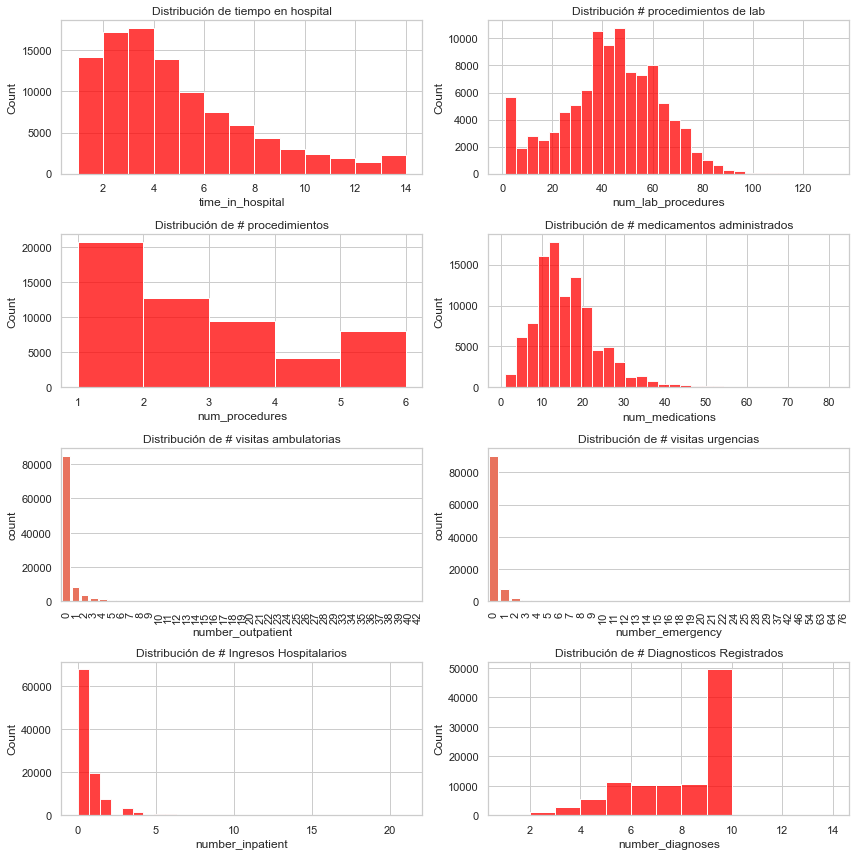

In [ ]:
#DIBUJAR HISTOGRAMAS
fig, axs = plt.subplots(4, 2, figsize=(12,12))  # 2 filas, 3 columnas
axs = axs.flatten()  # Aplanamos para indexar como una lista

sns.histplot(df['time_in_hospital'], bins=range(1, 15),ax=axs[0], color='red', kde=False)
axs[0].set_title('Distribución de tiempo en hospital')

sns.histplot(df['num_lab_procedures'], bins=30,ax=axs[1], color='red', kde=False)
axs[1].set_title('Distribución # procedimientos de lab')

sns.histplot(df['num_procedures'], bins=range(1,7),ax=axs[2], color='red', kde=False)
axs[2].set_title('Distribución de # procedimientos')

sns.histplot(df['num_medications'], bins=30,ax=axs[3], color='red', kde=False)
axs[3].set_title('Distribución de # medicamentos administrados')

sns.countplot(x='number_outpatient', data=df, color='tomato', ax=axs[4])
axs[4].set_title('Distribución de # visitas ambulatorias')
axs[4].tick_params(axis='x', labelrotation=90)

sns.countplot(x='number_emergency', data=df, color='tomato', ax=axs[5])
axs[5].set_title('Distribución de # visitas urgencias')
axs[5].tick_params(axis='x', labelrotation=90)

sns.histplot(df['number_inpatient'], bins=30,ax=axs[6], color='red', kde=False)
axs[6].set_title('Distribución de # Ingresos Hospitalarios')

sns.histplot(df['number_diagnoses'], bins=range(1,15),ax=axs[7], color='red', kde=False)
axs[7].set_title('Distribución de # Diagnosticos Registrados')

plt.tight_layout()


En esta imagen se pueden observar 8 diagramas de barras correspondientes a cada variable numérica. 
* **Tiempo en el Hospital (`time_in_hospital`):** La gráfica muestra una distribución claramente sesgada a la derecha. La mayoría de los pacientes permanecen en el hospital entre 2 y 5 días, siendo 4 días la duración más frecuente. A medida que aumenta el número de días, la frecuencia disminuye significativamente, lo que indica que solo una pequeña proporción de pacientes permanece más de 10 días hospitalizado.
* **Numero de Procedimientos de Laboratorio (`num_lab_procedures`):**  La distribución es ligeramente simétrica, con una concentración de valores entre 40 y 60 procedimientos, siendo alrededor de 50 la cantidad más frecuente. Aunque hay presencia de valores cercanos a cero, su frecuencia es considerablemente menor. Esta variable refleja una variabilidad moderada y una tendencia central bien definida.
* **Número de Procedimientos Distintos(`num_procedures`):** Se observa una distribución marcadamente sesgada a la derecha, ya que la mayor parte de los pacientes recibió solo un procedimiento. La frecuencia disminuye conforme aumenta el número de procedimientos, lo que indica que pocos pacientes son sometidos a más de 3 o 4 procedimientos.
* **Número de medicamentos (`num_medications`):** La gráfica indica que la mayoría de los pacientes recibió entre 10 y 20 medicamentos, siendo esta la moda. La distribución está ligeramente sesgada a la derecha, ya que existe un número reducido de pacientes a quienes se les administraron más de 40 medicamentos, aunque en menor proporción.
* **Número de visitas ambulatorias (`number_outpatient`):** Esta variable muestra una distribución altamente sesgada a la derecha, con una fuerte concentración de pacientes que no registraron visitas ambulatorias (valor 0). Existen algunos valores atípicos con más de 20 visitas, pero representan una fracción muy pequeña de los casos.
* **Número de visitas a urgencias (`number_emergency`):** Esta variable presenta una distribución fuertemente sesgada a la derecha, donde la gran mayoría de los pacientes no tuvo ninguna visita a urgencias. Las frecuencias caen drásticamente con el aumento en el número de visitas.
* **Número de ingresos hospitalarios (`number_inpatient`):** Se evidencia también un sesgo a la derecha, ya que la mayoría de los pacientes no reportaron ingresos hospitalarios recientes. Solo una pequeña parte de la población muestra múltiples ingresos, y estos casos son poco frecuentes.
* **Número de diagnósticos registrados (`number_diagnoses` ):** Esta muestra una distribución sesgada a la izquierda, con una clara concentración de pacientes que tienen 10 diagnósticos registrados, lo que representa el valor más frecuente. Los valores más bajos son menos comunes, lo que indica que la mayoría de los pacientes presenta un número alto de diagnósticos documentados.


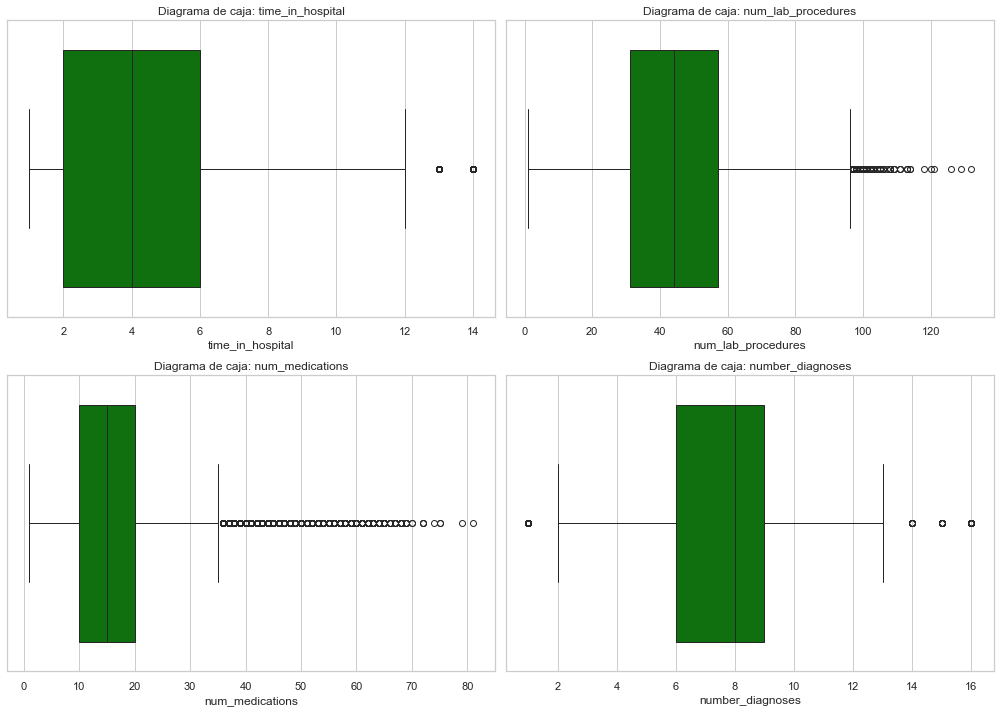

In [ ]:
# Lista de variables
columnas_boxplot = ['time_in_hospital', 'num_lab_procedures', 'num_medications', 'number_diagnoses']

# Crear figura con 2x2 subgráficos
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
axs = axs.flatten()

# Boxplots horizontales
for i, col in enumerate(columnas_boxplot):
    sns.boxplot(x=df[col], ax=axs[i], color='green')
    axs[i].set_title(f'Diagrama de caja: {col}', fontsize=12)
    axs[i].set_xlabel(col)

plt.tight_layout()
plt.show()

En la imagen anterior, se puede observar 4 gráficas de boxplot correspondientes a las variables numéricas con datos más relevantes, pues las cuatro restantes concentran sus datos cercanos a cero. 

Comenzando desde la parte superior izquierda, se observa el diagrama de caja correspondiente a la variable valor ***Tiempo en el Hospital (`time_in_hospital`)***. Este gráfico muestra que la mayoría de los pacientes estuvieron hospitalizados entre 2 y 6 días, lo que indica una concentración de valores en ese rango. La mediana se sitúa aproximadamente en 4 días. Se aprecia una distribución ligeramente sesgada a la derecha, ya que la mayor parte de los datos se encuentra en los valores más bajos. Además, se identifican dos valores atípicos en 13 y 14 días, lo que sugiere que unos pocos pacientes tuvieron estancias hospitalarias significativamente más prolongadas que el promedio.

Por otra parte, el diagrama de caja correspondiente a la variable ***Numero de Procedimientos de Laboratorio (`num_lab_procedures`)*** muestra que la mayoría de los pacientes se sometieron a entre 30 y 58 procedimientos de laboratorio, con una mediana cercana a los 45 procedimientos. Además, se observan múltiples valores atípicos por encima de los 97 procedimientos aproximadamente, lo que indica que algunos pacientes fueron sometidos a una cantidad inusualmente alta de exámenes.

Continuando con la parte inferior de la imagen, se encuentra la gráfica de la variable ***Número de medicamentos (`num_medications`)***. Esta indica que a la mayoría de los pacientes se les receta entre 10 a 20 medicamentos. La mediana se sitúa aproximadamente en 14 medicamentos. La distribución presenta un claro sesgo a la derecha, evidenciado por una gran cantidad de valores atípicos que superan los 35 medicamentos, alcanzando incluso cifras cercanas a 85. Esto sugiere que, aunque la mayoría de los pacientes recibió una cantidad moderada de medicamentos, existe un subconjunto que requirió tratamientos mucho más complejos, posiblemente debido a la presencia de múltiples complicaciones clínicas.

Por último, se presenta el diagrama de caja correspondiente a la variable ***Número de diagnósticos registrados (`number_diagnoses`)***. En este gráfico se observa una distribución relativamente simétrica, ya que la mediana se encuentra en una posición central, alrededor de los 8 diagnósticos por paciente. La mayoría de los datos se concentran entre aproximadamente 6 y 9 diagnósticos, lo que indica una baja dispersión en la parte central de la distribución. Se identifican cuatro valores atípicos: uno inferior cercano a 1 diagnóstico, y tres superiores, a partir de los 14 diagnósticos por paciente. Estos outliers indican que, aunque la mayoría de los pacientes recibe un número moderado de diagnósticos, existen casos excepcionales con cargas diagnósticas significativamente mayores o menores. En conjunto, este gráfico sugiere que la práctica médica tiende a generar entre 6 y 9 diagnósticos por paciente, aunque en ciertos casos particulares se observan registros considerablemente más extremos.

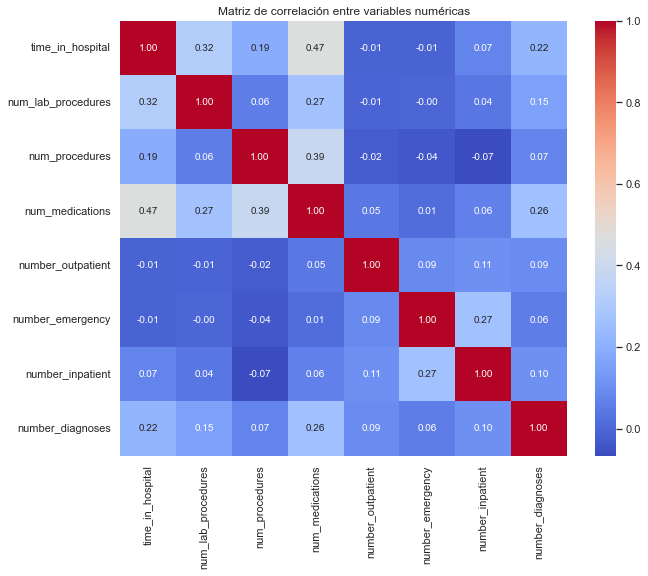

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[columnas_numericas].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación entre variables numéricas')
plt.show()

La matriz de correlación indica que no existen relaciones lineales fuertes entre las variables numéricas del conjunto de datos. La mayoría de los coeficientes de correlación se sitúan cerca de cero, lo que sugiere una asociación débil o inexistente entre las variables. La correlación más alta observada es de 0.47 entre `time_in_hospital` y `num_medications`, lo cual representa una relación moderada. También se evidencia una correlación leve de 0.39 entre `num_procedures` y `num_medications`. En general, los valores sugieren que las variables numéricas analizadas tienden a comportarse de manera independiente unas de otras.

### **2.2 Variables Categóricas**

#### **2.2.1 Resumen**

In [ ]:
# Crear lista con la info resumen de las variables categóricas
summary = []

for col in cat_cols:
    total = len(df)
    n_missing = df[col].isna().sum()
    n_unique = df[col].nunique(dropna=True)
    top = df[col].value_counts(dropna=True).idxmax()
    freq = df[col].value_counts(dropna=True).max()
    top_pct = (freq / total) * 100

    summary.append({
        'Variable': col,
        'Categorías únicas': n_unique,
        'Valor más frecuente': top,
        'Frecuencia': freq,
        '% del más frecuente': round(top_pct, 2),
        'Nulos': n_missing
    })

# Convertir a DataFrame para visualizar como tabla
summary_df = pd.DataFrame(summary)

# Ordenar si deseas
summary_df = summary_df.sort_values(by='Categorías únicas', ascending=False)

# Mostrar como tabla
summary_df.style.set_caption("Resumen de variables categóricas")

,Variable,Categorías únicas,Valor más frecuente,Frecuencia,% del más frecuente,Nulos
4,medical_specialty,73,71.000000,49949,49.080000,0
7,diag_3,20,2.000000,31729,31.180000,0
5,diag_1,20,2.000000,30458,29.930000,0
6,diag_2,20,2.000000,32239,31.680000,0
3,payer_code,18,16.000000,40256,39.560000,0
2,age,10,7.000000,26068,25.620000,0
0,race,5,2.000000,78372,77.010000,0
28,glyburide-metformin,4,1.000000,101060,99.310000,0
8,max_glu_serum,4,3.000000,96420,94.750000,0
9,A1Cresult,4,3.000000,84748,83.280000,0


***Interpretación***

El resumen de las variables categóricas revela una alta proporción de valores dominantes en la mayoría de las variables. Por ejemplo, variables como glyburide-metformin, metformin-pioglitazone, glipizide-metformin, troglitazone, entre otras, presentan una distribución extremadamente desbalanceada, con un único valor que representa el 100% o casi el 100% de los casos, lo cual indica una falta de variabilidad y sugiere que podrían no aportar información útil al modelo o análisis. En contraste, variables como race, gender y readmitted muestran distribuciones más heterogéneas, con porcentajes más bajos del valor más frecuente, lo que las convierte en candidatas más informativas. Asimismo, algunas variables como medical_specialty y payer_code presentan una alta cantidad de categorías (73 y 18 respectivamente), lo cual podría introducir complejidad en el análisis y requerir estrategias como agrupación o codificación especial. Finalmente, ninguna de las variables categóricas contiene valores nulos, lo cual facilita su procesamiento posterior.

#### **2.2.2. Gráficos**

In [ ]:

cat_ident = [
    'encounter_id', 'patient_nbr'
]
n_cols_ident = len(cat_ident)

cat_dem_ing = [
    'race', 'gender', 'age', 'admission_type_id',
    'discharge_disposition_id', 'admission_source_id',
    'time_in_hospital'
]
n_cols_dem_ing = len(cat_dem_ing)

cat_prue_proced = [
    'num_lab_procedures', 'num_procedures', 'num_medications',
    'number_outpatient', 'number_emergency', 'number_inpatient',
    'number_diagnoses'
]
n_cols_prue_proced = len(cat_prue_proced)

cat_diag_princ = [
    'diag_1', 'diag_2', 'diag_3' 
]
n_cols_diag_princ= len(cat_diag_princ)

cat_resultados_lab = [
    'max_glu_serum', 'A1Cresult'
]
n_cols_resultados_lab = len(cat_resultados_lab)

cat_meds = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
    'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
    'miglitol', 'troglitazone', 'tolazamide', 'examide',
    'citoglipton', 'insulin', 'glyburide-metformin',
    'glipizide-metformin', 'glimepiride-pioglitazone',
    'metformin-rosiglitazone', 'metformin-pioglitazone'
]
n_cols_meds = len(cat_meds)

cat_control_tratamiento = [
    'change', 'diabetesMed'
]
n_cols_control_tratamiento = len(cat_control_tratamiento)

cat_objetivo = [
    'readmitted'
]
n_cols_objetivo = len(cat_objetivo)


In [ ]:
def graficar_cat(n_cols, cat, figura_num=1, titulo_general=None, palette='Set2'):
    import math
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Número de columnas fijas
    cols = 3
    rows = math.ceil(n_cols / cols)

    # Crear figura
    fig, axs = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
    axs = axs.flatten()

    for i, col in enumerate(cat):
        ax = axs[i]
        n_cat = df[col].nunique()

        if n_cat <= 10:
            orden = df[col].value_counts().sort_values(ascending=False).index
            sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)
        else:
            top_10 = df[col].value_counts().nlargest(10)
            categorias_ordenadas = top_10.index
            frecuencias = top_10.values
            sns.barplot(x=categorias_ordenadas, y=frecuencias, ax=ax, palette=palette)

        ax.set_title(f'{col} ({n_cat} cat.)', fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('Frecuencia')
        ax.tick_params(axis='x', rotation=45)

    # Eliminar ejes vacíos
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    # Ajustar el espacio automáticamente
    plt.tight_layout(rect=[0, 0.05, 1, 0.93])  # deja espacio para el título y el pie

    # Título general centrado
    if titulo_general:
        fig.text(0.5, 0.96, titulo_general, ha='center', fontsize=16, weight='bold')

    # Pie de figura centrado
    fig.text(0.5, 0.02, f'Figura {figura_num}. {titulo_general}', ha='center', fontsize=12)
    

    plt.show()


#####  **2.2.2.1. Distribución de Variables Demográficas y de Ingreso**

C:\Users\Janus\AppData\Local\Temp/ipykernel_18804/2211837392.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)
C:\Users\Janus\AppData\Local\Temp/ipykernel_18804/2211837392.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)
C:\Users\Janus\AppData\Local\Temp/ipykernel_18804/2211837392.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)
C:\Users\Janus\AppData\Local\Temp/ipyker

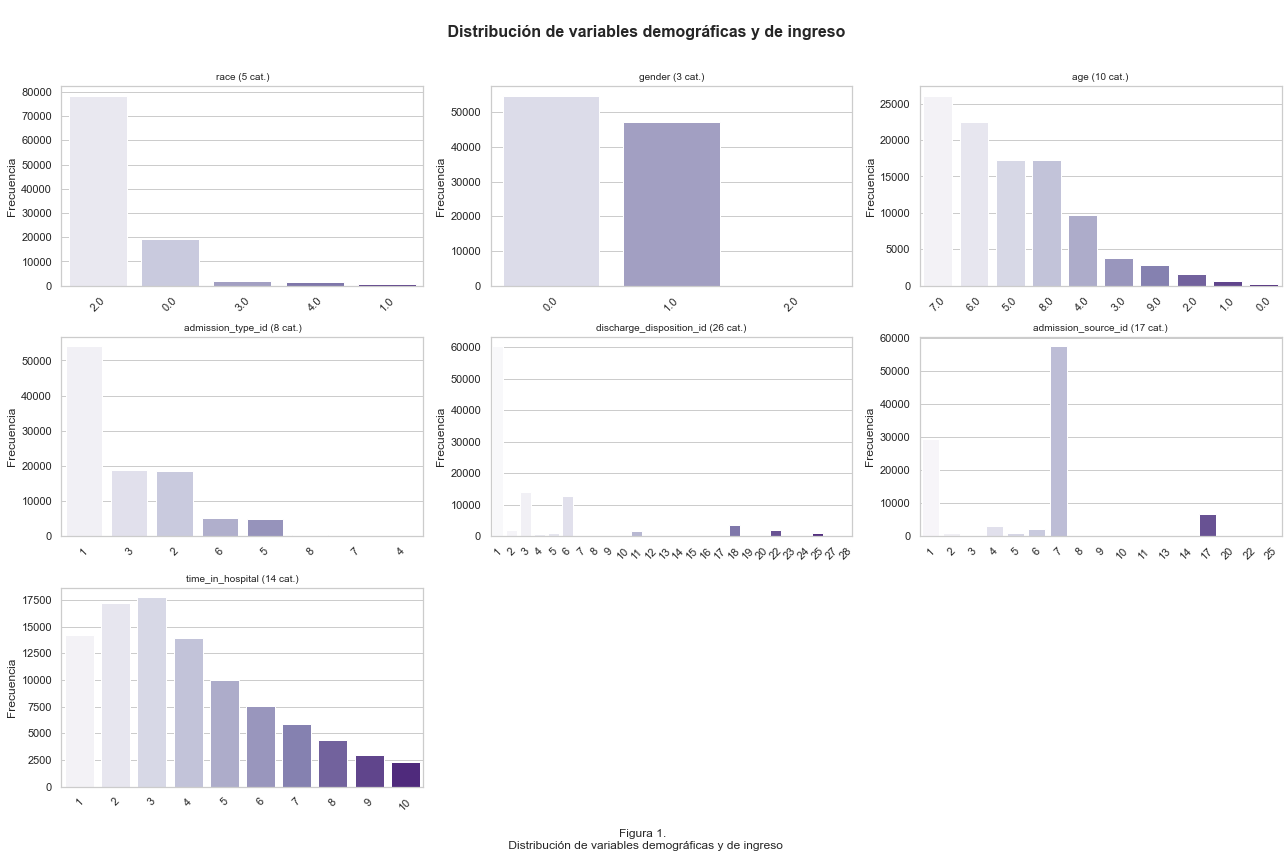

In [ ]:
graficar_cat(n_cols_dem_ing, cat_dem_ing, figura_num=1,
             titulo_general='\n Distribución de variables demográficas y de ingreso',
             palette='Purples')  # o 'Blues', 'coolwarm', etc.

La figura presenta la distribución de varias variables categóricas relacionadas con las características demográficas de los pacientes y su ingreso hospitalario.

- **Raza (`race`)**:  
  Se observa que la mayoría de los pacientes se identifican como **raza 2**, lo cual, según la codificación del dataset, corresponde a pacientes **caucásicos**. Las otras categorías (como afroamericanos, hispanos, asiáticos y otros) tienen una representación mucho menor.

- **Género (`gender`)**:  
  Hay una leve mayoría de pacientes de **género 2**, que corresponde a **femenino**, seguido por **género 1**, que es **masculino**. La categoría **0** (desconocido o inválido) es mínima.

- **Edad (`age`)**:  
  La mayoría de los pacientes se encuentran entre **60 y 80 años**, lo cual es coherente con el hecho de que la **diabetes tipo 2** y sus complicaciones son más comunes en adultos mayores.  
  Los intervalos de edad están codificados (ej. `0 = [0–10)`, `1 = [10–20)`, etc.), pero visualmente se evidencia que los valores más frecuentes son de adultos mayores.

- **Tipo de ingreso (`admission_type_id`)**:  
  La categoría más frecuente es la **1**, que corresponde a **urgencias**.  
  Esto indica que la mayoría de las hospitalizaciones fueron por situaciones **no planificadas**.  
  Otras formas de ingreso como consultas referidas o ingreso electivo son mucho menos comunes.

- **Condición de alta (`discharge_disposition_id`)**:  
  Aunque esta variable tiene muchas categorías, destacan:  
  la **1 (alta a casa)**, seguida por algunas otras como la **3 (alta a otro hospital)** o la **6 (paciente fallecido)**.  
  Esto da una idea de cómo se resolvió la hospitalización.

- **Fuente de ingreso (`admission_source_id`)**:  
  Se observa un gran predominio de la categoría **7**, que en este caso representa **ingresos desde la sala de emergencias**.  
  Esto refuerza lo anterior, donde se evidenció que la mayoría de pacientes ingresan por urgencia.

- **Tiempo en el hospital (`time_in_hospital`)**:  
  Aunque hay varios valores, la mayor parte de los pacientes estuvo entre **1 y 4 días** hospitalizados, con una disminución progresiva en los valores mayores.  
  Esto sugiere estancias hospitalarias **relativamente cortas** para la mayoría.

##### **2.2.2.2. Distribución de Pruebas, Procedimientos y Medicamentos**

C:\Users\Janus\AppData\Local\Temp/ipykernel_18804/2211837392.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categorias_ordenadas, y=frecuencias, ax=ax, palette=palette)
C:\Users\Janus\AppData\Local\Temp/ipykernel_18804/2211837392.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)
C:\Users\Janus\AppData\Local\Temp/ipykernel_18804/2211837392.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categorias_ordenadas, y=frecuencias, ax=ax, palette=palette)
C:\Users\Janus\AppData\L

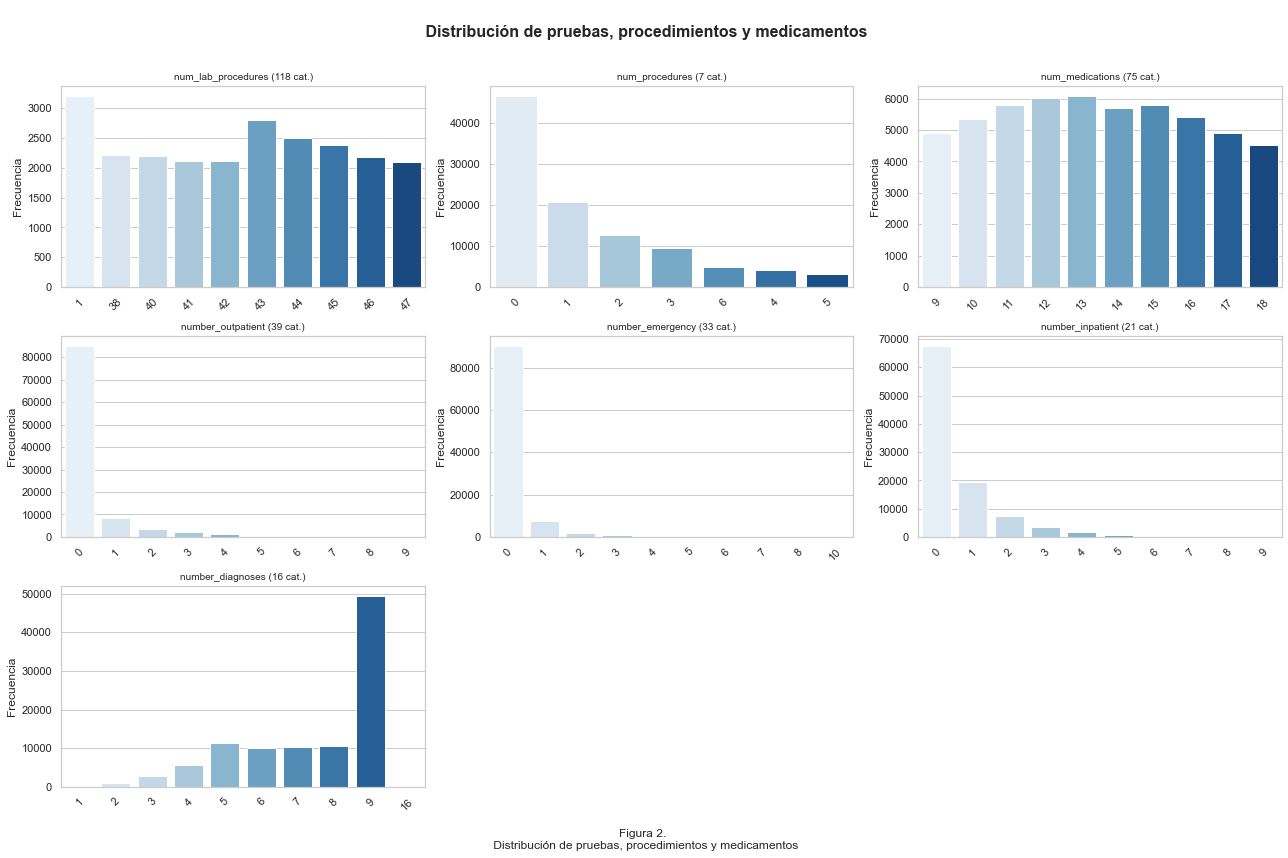

In [ ]:
graficar_cat(n_cols_prue_proced, cat_prue_proced, figura_num=2,
             titulo_general='\n Distribución de pruebas, procedimientos y medicamentos',
             palette='Blues')

La figura muestra la distribución de diferentes variables relacionadas con los procedimientos médicos, las pruebas realizadas y el número de medicamentos administrados durante las hospitalizaciones.

- **Número de procedimientos de laboratorio (`num_lab_procedures`)**:  
  Esta variable tiene muchas categorías (118), pero se observa que hay una concentración importante en valores entre 40 y 70 procedimientos por paciente. Es decir, la mayoría de los pacientes tuvieron una cantidad intermedia de pruebas de laboratorio, lo que sugiere un nivel de monitoreo moderado durante la hospitalización.

- **Número de procedimientos (`num_procedures`)**:  
  En este caso, la mayoría de los pacientes tuvo **cero o un procedimiento** médico. Las frecuencias disminuyen progresivamente a medida que aumenta el número de procedimientos, lo que indica que la intervención médica directa no fue tan alta en la mayoría de los casos.

- **Número de medicamentos (`num_medications`)**:  
  Hay una clara tendencia a la alta cantidad de medicamentos administrados. Las categorías más frecuentes están entre **10 y 18 medicamentos**, lo que podría indicar tratamientos complejos o presencia de múltiples condiciones médicas.

- **Consultas externas (`number_outpatient`)**:  
  La mayoría de los pacientes no tuvo consultas externas previas a la hospitalización (valor 0). Solo una pequeña proporción tuvo una o más visitas ambulatorias, lo que sugiere que muchos ingresos fueron inesperados o sin seguimiento ambulatorio reciente.

- **Visitas a emergencias (`number_emergency`)**:  
  Al igual que en el caso anterior, la mayoría de los pacientes no tuvo visitas previas a emergencias antes de ser hospitalizados. Esto puede reforzar la idea de que muchos ingresos fueron por primera atención de una complicación aguda.

- **Consultas internas previas (`number_inpatient`)**:  
  Se observa que la mayoría no tuvo hospitalizaciones anteriores (valor 0), aunque existe una pequeña proporción que ha sido hospitalizada previamente en múltiples ocasiones, lo que puede reflejar casos más crónicos o severos.

- **Cantidad de diagnósticos (`number_diagnoses`)**:  
  La mayoría de los pacientes tiene registrados **nueve diagnósticos**, que es el valor máximo permitido por la base de datos. Esto indica que muchos pacientes presentan **múltiples condiciones de salud**, lo que puede reflejar la complejidad clínica del grupo.

##### **2.2.2.3. Distribución de Diagnósticos**

C:\Users\Janus\AppData\Local\Temp/ipykernel_18804/2211837392.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categorias_ordenadas, y=frecuencias, ax=ax, palette=palette)
C:\Users\Janus\AppData\Local\Temp/ipykernel_18804/2211837392.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categorias_ordenadas, y=frecuencias, ax=ax, palette=palette)
C:\Users\Janus\AppData\Local\Temp/ipykernel_18804/2211837392.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categorias_ordenadas, y=frecuencias, ax=ax, palette=palette)


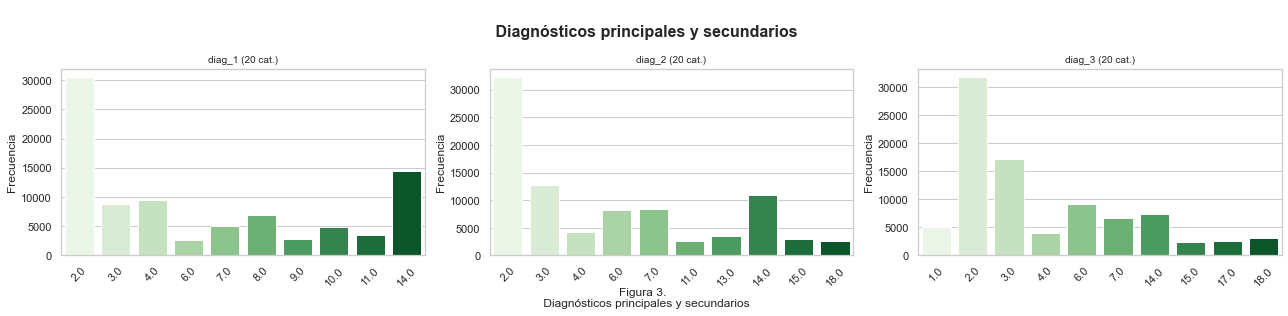

In [ ]:
graficar_cat(n_cols_diag_princ, cat_diag_princ, figura_num=3,
             titulo_general='\n Diagnósticos principales y secundarios',
             palette='Greens')

Esta figura muestra la distribución de los diagnósticos principales (`diag_1`) y secundarios (`diag_2`, `diag_3`) registrados para cada paciente. Las categorías representan grupos de enfermedades, basados en los códigos ICD-9 agrupados por rangos.

- **Diagnóstico principal (`diag_1`)**:  
  La categoría más frecuente es la **2.0**, relacionada con enfermedades del sistema circulatorio. Le sigue la categoría **14.0**, que representa los diagnósticos de diabetes (por ejemplo, códigos 250.xx). Esta combinación muestra que muchos pacientes ingresan al hospital con complicaciones cardíacas o directamente por complicaciones derivadas de la diabetes.

- **Segundo diagnóstico (`diag_2`)**:  
  De nuevo, la categoría **2.0** sobresale por mucho, indicando que muchas personas presentan enfermedades cardiovasculares como condición secundaria. Le siguen las categorías **3.0** (enfermedades del sistema respiratorio) y **14.0** (diabetes), con frecuencias similares. Esto refleja que, en pacientes con múltiples condiciones, es muy común ver esta combinación de enfermedades circulatorias, respiratorias y metabólicas.

- **Tercer diagnóstico (`diag_3`)**:  
  En este caso, la categoría **2.0** continúa siendo la más común, y la **3.0** le sigue con una frecuencia notable —un poco más de la mitad de la que tiene la categoría 2.0. Esta tendencia refuerza la idea de que las enfermedades del corazón y pulmón son condiciones crónicas recurrentes en pacientes hospitalizados, muchas veces en conjunto con la diabetes.

##### **2.2.2.4 Distribución de Resultados de Laboratorio**

C:\Users\Janus\AppData\Local\Temp/ipykernel_18804/2211837392.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)
C:\Users\Janus\AppData\Local\Temp/ipykernel_18804/2211837392.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)


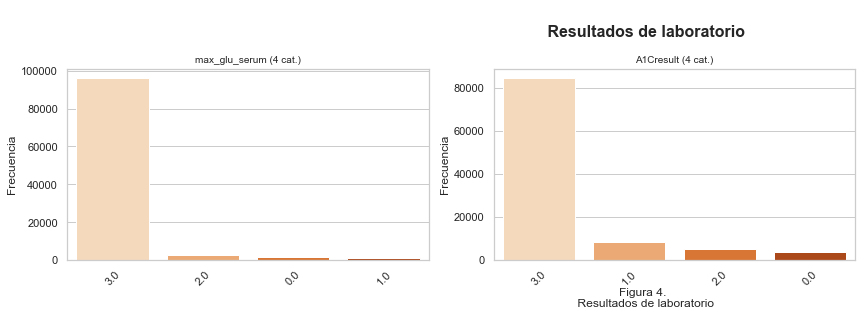

In [ ]:
graficar_cat(n_cols_resultados_lab, cat_resultados_lab, figura_num=4,
             titulo_general='\n Resultados de laboratorio',
             palette='Oranges')


Esta figura muestra la distribución de dos variables relacionadas con exámenes clínicos importantes en el control de la diabetes: `max_glu_serum` (nivel máximo de glucosa en suero) y `A1Cresult` (resultado del examen de hemoglobina glicosilada).

- **Nivel máximo de glucosa en suero (`max_glu_serum`)**:  
  La mayoría de los registros se encuentran en la categoría **3.0**, que corresponde a **"No se realizó el test"**. Esto indica que para la gran mayoría de pacientes no se midió el valor máximo de glucosa durante su estancia hospitalaria. Las demás categorías (0.0, 1.0, 2.0) tienen frecuencias muy bajas, lo que sugiere que cuando sí se hace la prueba, es en muy pocos casos.

- **Resultado del examen A1C (`A1Cresult`)**:  
  Al igual que en la variable anterior, la categoría más frecuente es la **3.0**, lo que también significa que **no se realizó el test de hemoglobina glicosilada**. Las otras tres categorías (0.0: "normal", 1.0: ">7", 2.0: ">8") están presentes pero con frecuencias mucho menores. Esto puede implicar que el seguimiento a largo plazo del control glucémico no se hace de manera sistemática en los pacientes hospitalizados.


##### **2.2.2.5. Distribución de Medicamentos Administrados Durante la Estancia**

C:\Users\Janus\AppData\Local\Temp/ipykernel_18804/2211837392.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)
C:\Users\Janus\AppData\Local\Temp/ipykernel_18804/2211837392.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)
C:\Users\Janus\AppData\Local\Temp/ipykernel_18804/2211837392.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)
C:\Users\Janus\AppData\Local\Temp/ipyker

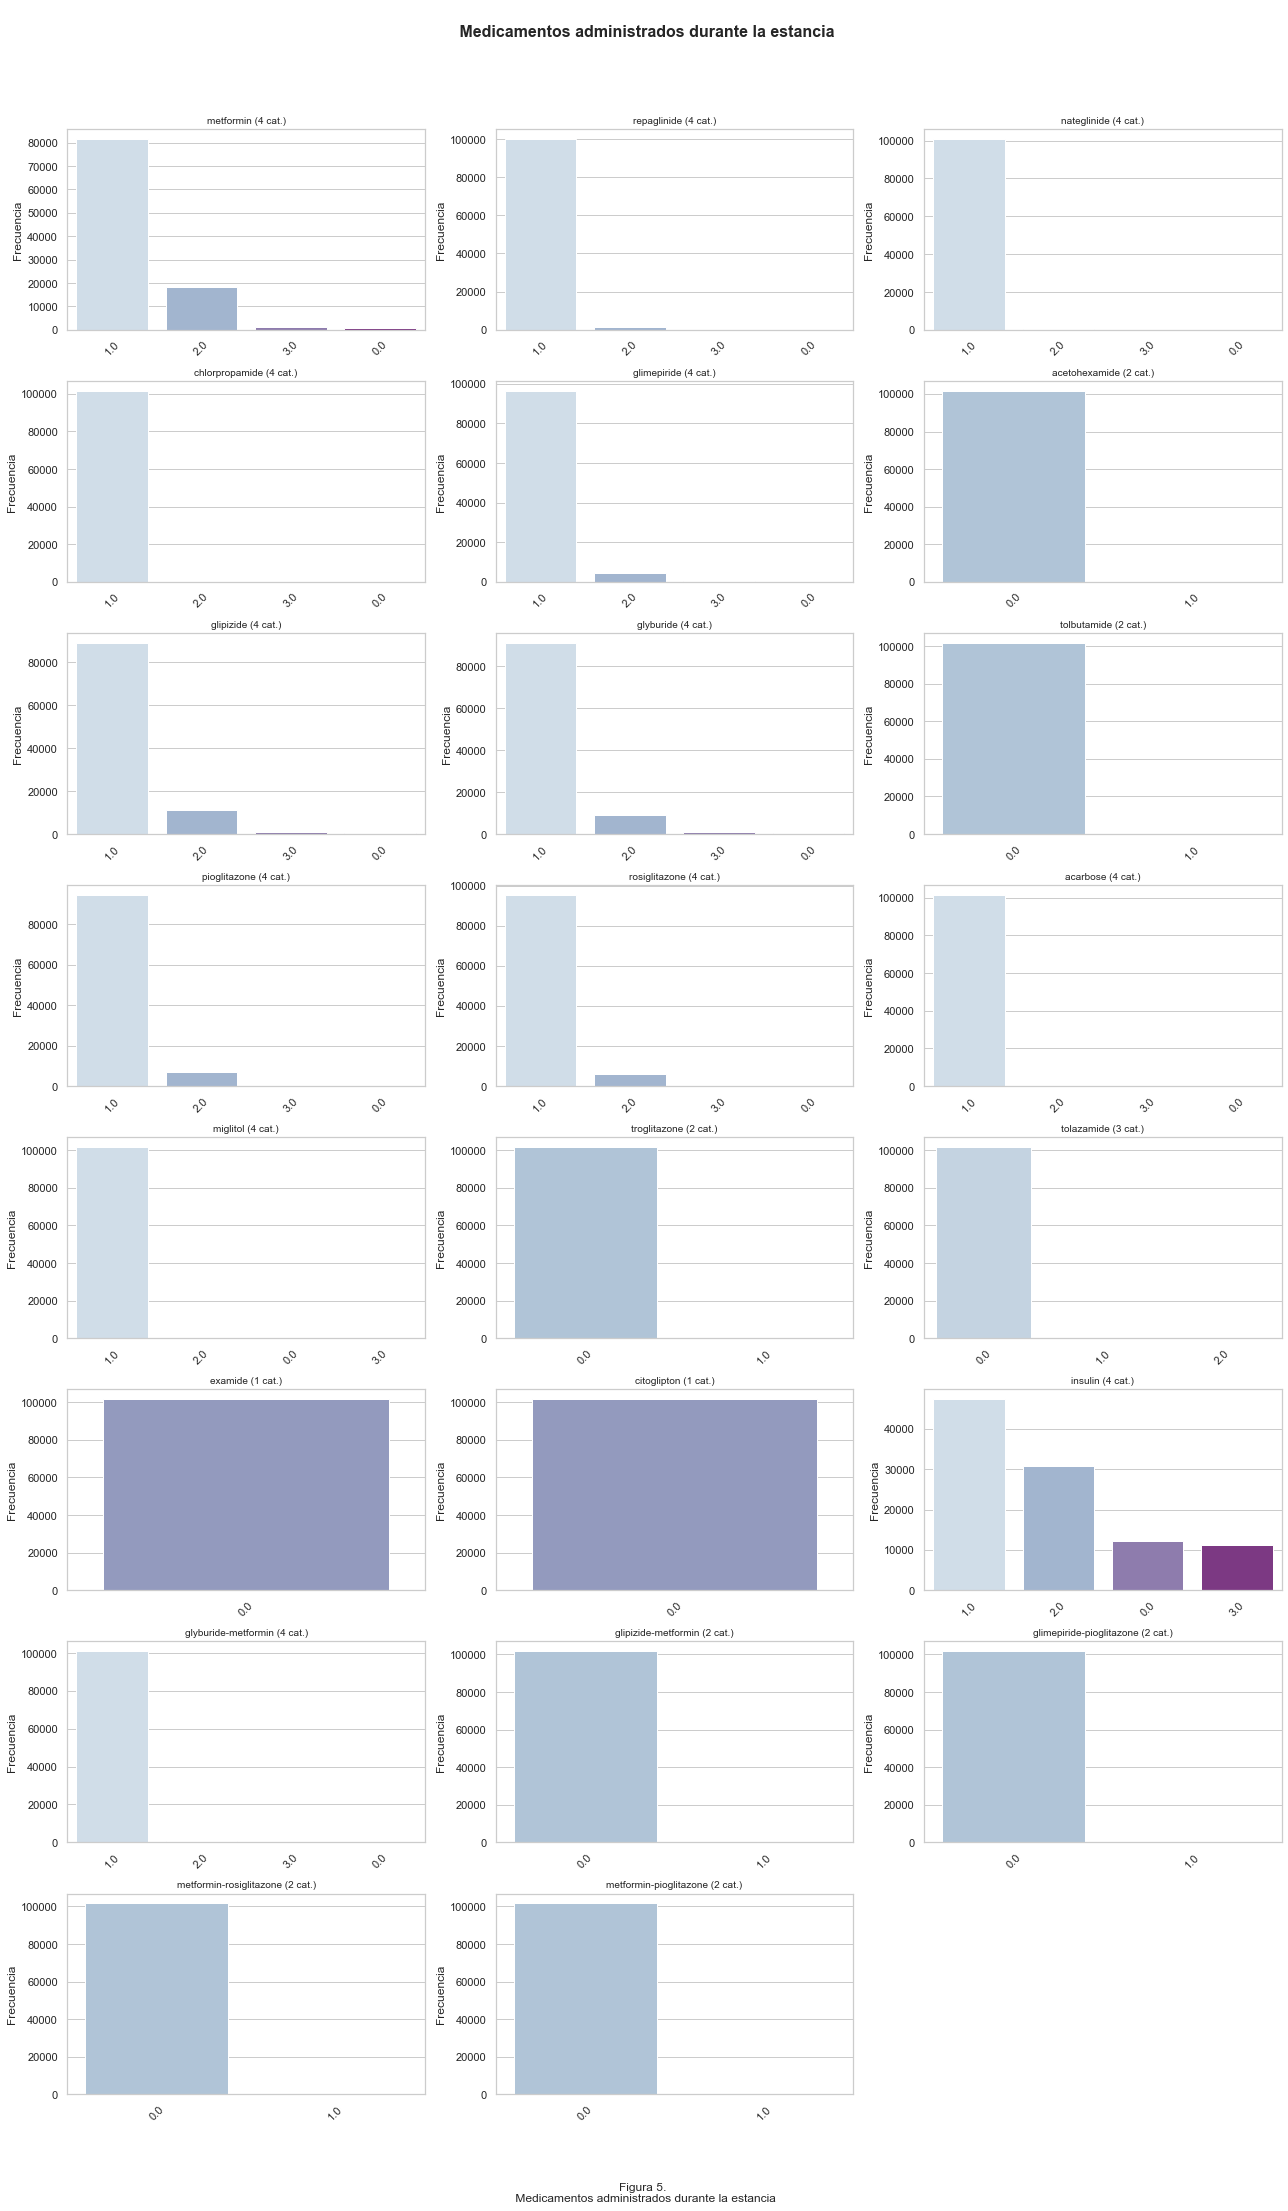

In [ ]:
graficar_cat(n_cols_meds, cat_meds, figura_num=5,
             titulo_general='\n Medicamentos administrados durante la estancia',
             palette='BuPu')

Esta figura presenta la distribución de diferentes medicamentos utilizados en pacientes hospitalizados con diagnóstico de diabetes. 

- En general, la mayoría de los medicamentos individuales (como `metformin`, `glimepiride`, `glyburide`, `pioglitazone`, entre otros) tienen como categoría más común el valor **1.0**, lo que indica que **la medicación no cambió durante la estancia**. Es decir, los pacientes que ya estaban tomando estos medicamentos continuaron con ellos.

- Las categorías **2.0** (medicación añadida) y **3.0** (medicación discontinuada) aparecen con menor frecuencia. En la mayoría de los casos, la categoría **0.0** (medicación nunca utilizada) tiene una baja frecuencia, **excepto en medicamentos poco comunes**, como `acetohexamide`, `tolazamide` o combinaciones poco frecuentes.

- En los **medicamentos combinados** (como `glyburide-metformin`, `glipizide-metformin`, `metformin-pioglitazone`), se observa que la mayoría de los pacientes **no recibieron estas combinaciones durante la hospitalización**. Esto puede deberse a que estas terapias son más comunes en tratamientos ambulatorios que en contextos agudos.

- Una excepción interesante es la **insulina**, donde las frecuencias están distribuidas entre todas las categorías. Esto indica que **sí hubo ajustes importantes en su administración**, probablemente en respuesta a las necesidades clínicas inmediatas de los pacientes hospitalizados.


##### **2.2.2.6 Distribución Control del Tratamiento Para la Diabetes**

C:\Users\Janus\AppData\Local\Temp/ipykernel_18804/2211837392.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)
C:\Users\Janus\AppData\Local\Temp/ipykernel_18804/2211837392.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)


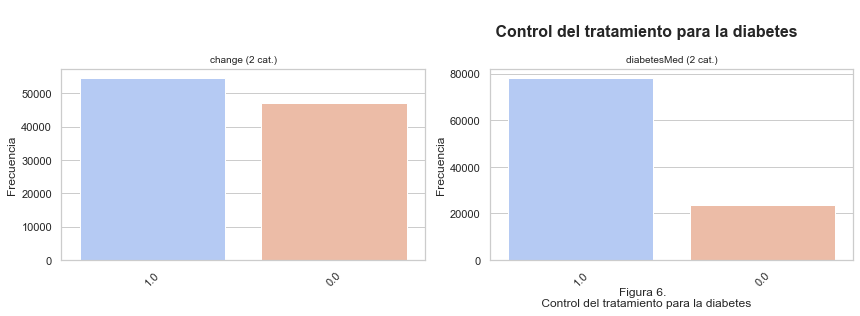

In [ ]:
graficar_cat(n_cols_control_tratamiento, cat_control_tratamiento, figura_num=6,
             titulo_general='\n Control del tratamiento para la diabetes',
             palette='coolwarm')



Esta figura presenta la distribución de dos variables relacionadas con el control del tratamiento de pacientes hospitalizados con diagnóstico de diabetes.

- En el gráfico izquierdo, correspondiente a la variable `change`, se observa que la mayoría de los pacientes presentan un valor de **1.0**, lo que indica que **hubo un cambio en la medicación durante la hospitalización**. Este comportamiento sugiere que, en muchos casos, el tratamiento fue ajustado, probablemente en respuesta a evaluaciones médicas o complicaciones agudas. No obstante, una cantidad considerable de pacientes también se mantuvo con su tratamiento sin cambios (`0.0`), lo que podría reflejar condiciones estables o seguimiento de un protocolo ya establecido.

- En el gráfico derecho, correspondiente a la variable `diabetesMed`, se destaca que la mayoría de los pacientes tienen un valor de **1.0**, lo que significa que **recibieron medicación para la diabetes durante su estancia hospitalaria**. En contraste, una proporción menor de pacientes (`0.0`) no recibió medicación, lo cual puede deberse a múltiples factores, como estadías cortas, control dietético, o decisiones clínicas específicas. La predominancia del uso de medicamentos refleja la importancia del tratamiento farmacológico en el manejo hospitalario de la diabetes.

Ambas variables reflejan la dinámica del tratamiento médico en contextos hospitalarios, evidenciando tanto la alta tasa de intervención como la adaptación del manejo clínico según las condiciones del paciente.

##### **2.2.2.7. Distribución de la variable objetivo (readmisión)**

C:\Users\Janus\AppData\Local\Temp/ipykernel_18804/2211837392.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)


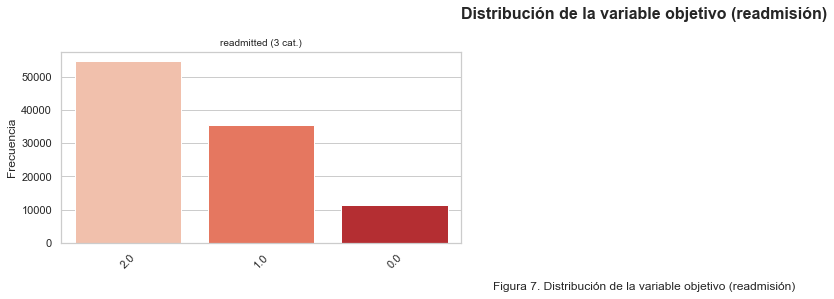

In [ ]:
graficar_cat(n_cols_objetivo, cat_objetivo, figura_num=7,
             titulo_general='Distribución de la variable objetivo (readmisión)',
             palette='Reds')

El gráfico revela que la mayoría de los pacientes no fueron readmitidos (`2.0`), con una frecuencia superior a 50.000 casos. En segundo lugar se encuentran los pacientes que sí fueron readmitidos, pero después de 30 días (`1.0`), y finalmente, con una frecuencia mucho menor, los pacientes que fueron readmitidos antes de 30 días (`0.0`).

### **2.3 Variables Cruzadas**

#### **2.3.1. Variables Numéricas** 

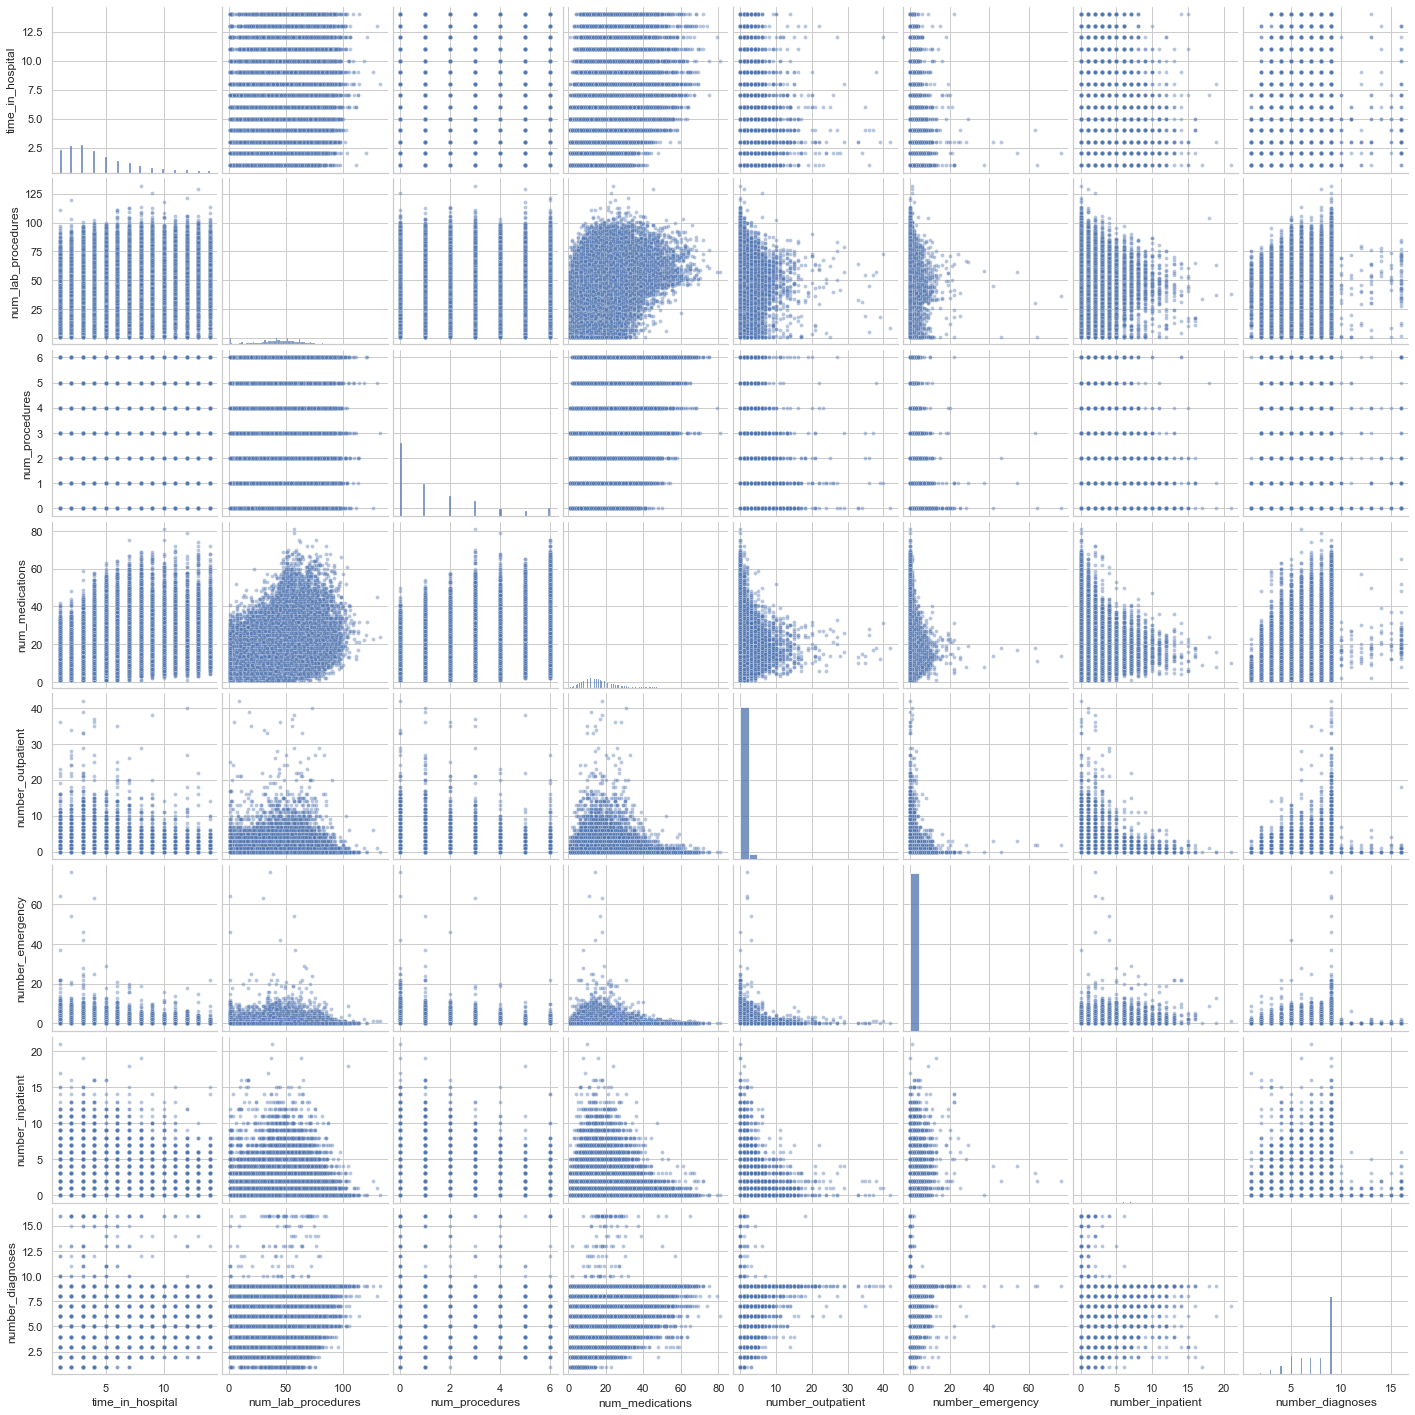

In [ ]:
cols_interes = ["time_in_hospital","num_lab_procedures","num_procedures", "num_medications",
"number_outpatient","number_emergency","number_inpatient","number_diagnoses"]
sns.pairplot(df[cols_interes], plot_kws={'alpha':0.4, 's':15})

Como análisis general, en la matriz de dispersión no se aprecian relaciones lineales claras o fuertes entre la mayoría de las variables numéricas, lo que coincide con lo observado en la matriz de correlación, donde no se identificaron valores de 𝑟^2 elevados. En su lugar, predominan correlaciones débiles o negativas, lo que sugiere que estas variables, de forma individual, podrían tener una capacidad limitada para explicar la variabilidad de otras dentro del conjunto de datos.

#### **2.3.2. Variables Categóricas**

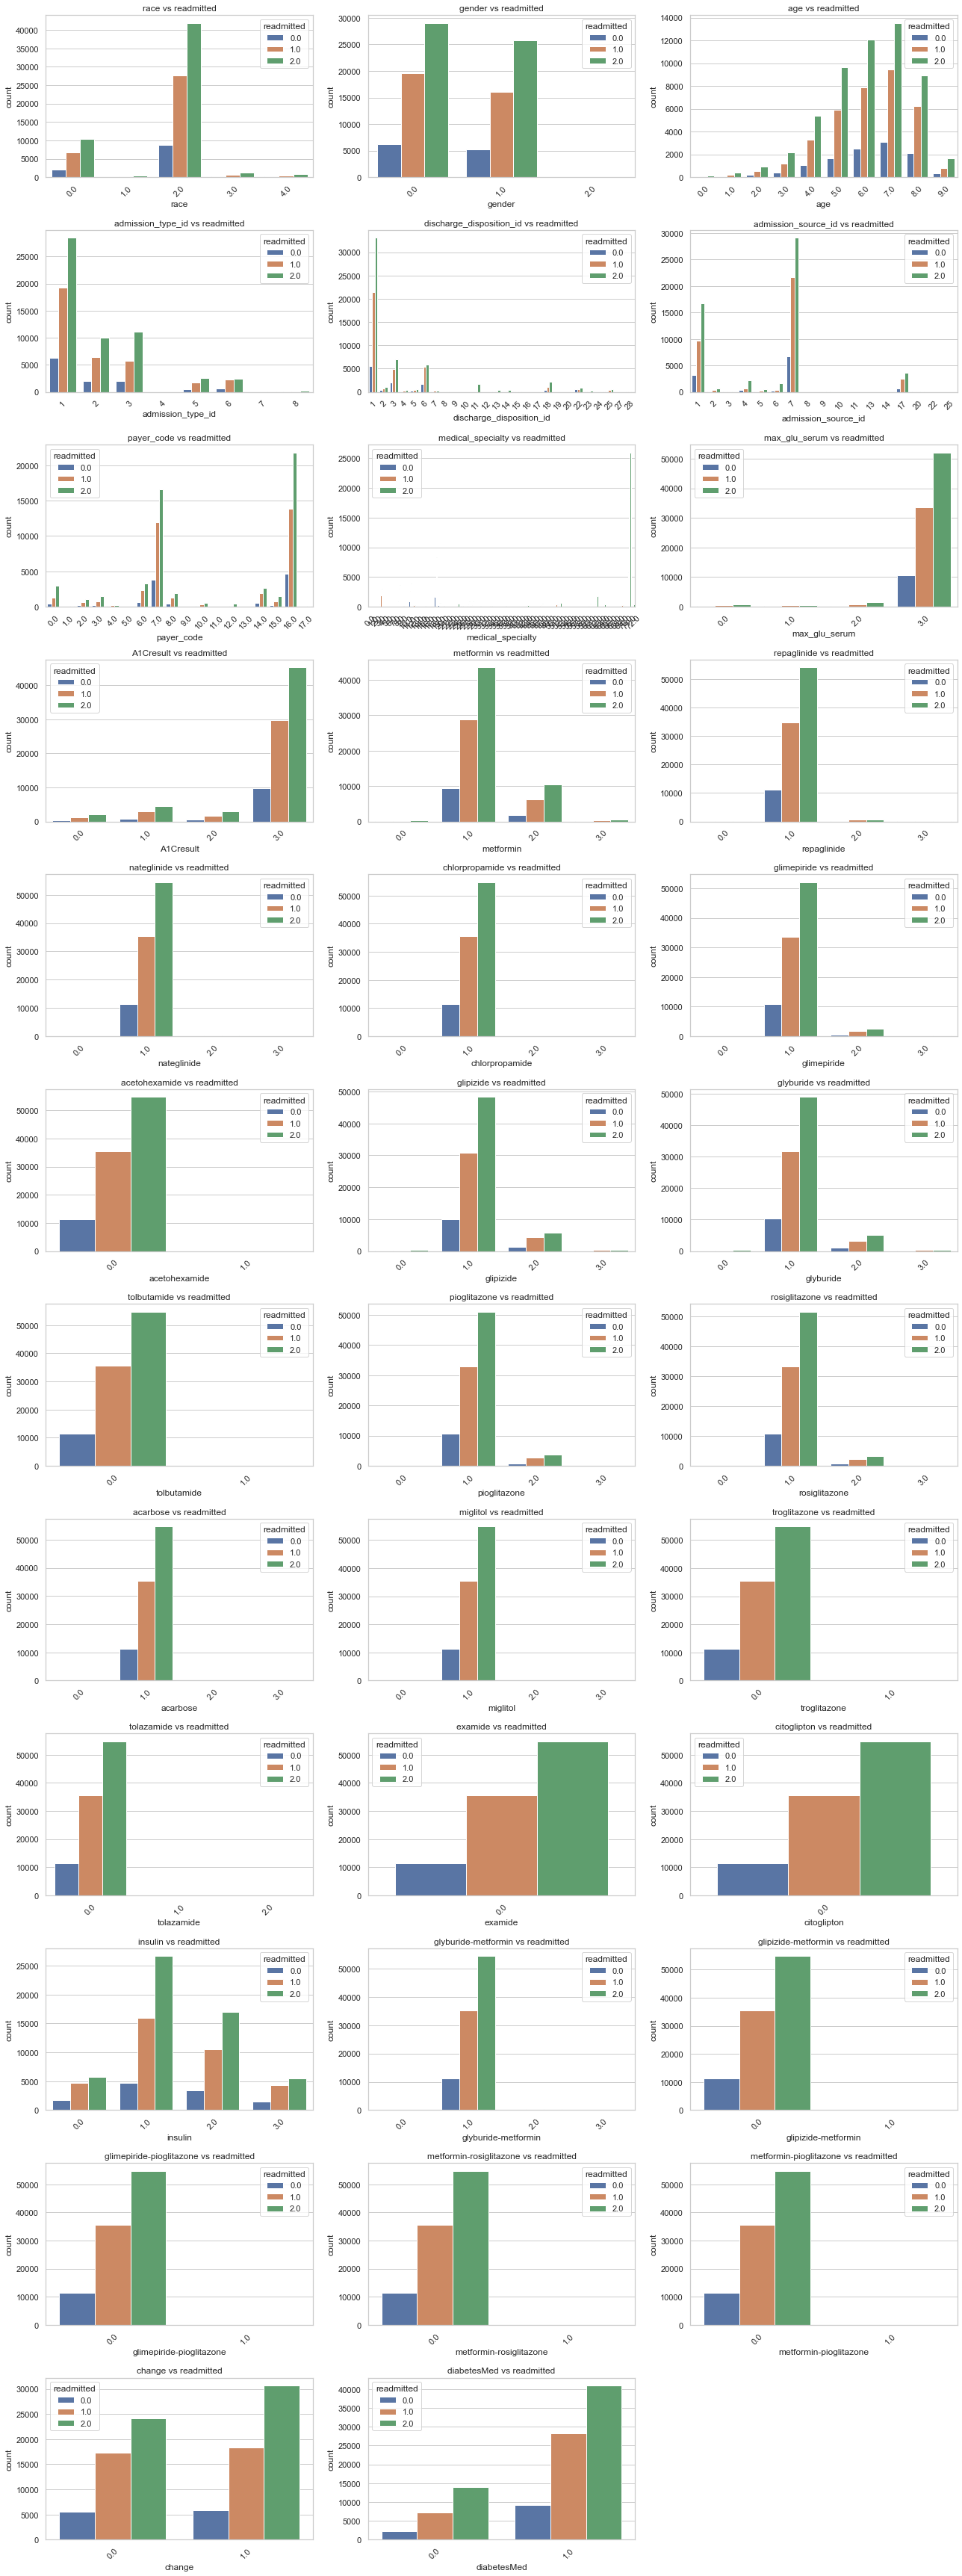

In [ ]:
# Variables categóricas (excepto 'readmitted')
categorical_vars = df.select_dtypes(include=['object','category']).columns.drop('readmitted')

# Definir tamaño de la cuadrícula
n_cols = 3  # número de gráficos por fila
n_rows = math.ceil(len(categorical_vars) / n_cols)  # filas necesarias

# Crear la figura
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*4))
axes = axes.flatten()  # para iterar fácilmente

# Graficar cada variable en un subplot
for i, col in enumerate(categorical_vars):
    sns.countplot(x=col, hue='readmitted', data=df, ax=axes[i])
    axes[i].set_title(f"{col} vs readmitted")
    axes[i].tick_params(axis='x', rotation=45)

# Eliminar ejes vacíos si sobran
for j in range(i+1, len(axes)): 
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


De forma general, en estas gráficas se observa que, para la mayoría de las variables categóricas, una gran proporción de los pacientes corresponde a aquellos que no han sido readmitidos en el hospital. Este patrón se repite de manera consistente, independientemente de la variable analizada, lo que sugiere que la clase de no readmisión es predominante en el conjunto de datos. Si bien algunas variables como race, gender o age muestran una distribución más equilibrada entre sus categorías internas, la tendencia general sigue favoreciendo a los pacientes sin readmisión.

En conjunto, no se identifican patrones categóricos evidentes que permitan diferenciar de forma clara a los pacientes según su estado de readmisión únicamente a partir de estas variables. Sin embargo, se detecta que ciertas variables con un mayor número de categorías —como medical_specialty o payer_code— podrían contener información útil si se agrupan o transforman para reducir la dispersión y aumentar su representatividad. Asimismo, variables relacionadas con tratamientos o medicación, aunque concentradas en pocas categorías, podrían aportar valor predictivo al combinarse con otras variables en un modelo multivariado, ya que podrían reflejar prácticas clínicas o perfiles de pacientes asociados con un mayor riesgo de readmisión.